In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
import torch
from torch.utils.data import random_split
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
import os
import random
from shutil import copy2
from PIL import Image
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
import matplotlib.pyplot as plt

In [3]:
dataset_path = "/content/drive/MyDrive/Paddy_Images_train"

In [4]:
classes = os.listdir(dataset_path)
classes = [c for c in classes if os.path.isdir(os.path.join(dataset_path, c))]
classes.sort()

print("Total Classes:", len(classes))
print("\nImages per class:\n")

for cls in classes:
    folder_path = os.path.join(dataset_path, cls)
    num_imgs = len(os.listdir(folder_path))
    print(f"{cls}: {num_imgs} images")


Total Classes: 10

Images per class:

bacterial_leaf_blight: 479 images
bacterial_leaf_streak: 380 images
bacterial_panicle_blight: 337 images
blast: 1738 images
brown_spot: 965 images
dead_heart: 1442 images
downy_mildew: 620 images
hispa: 1594 images
normal: 1764 images
tungro: 1088 images


In [8]:
sample_class = random.choice(classes)
sample_image_path = os.path.join(dataset_path, sample_class, random.choice(os.listdir(os.path.join(dataset_path, sample_class))))

img = Image.open(sample_image_path)
print("Sample image path:", sample_image_path)
print("Image size:", img.size)   # (width, height)
print("Mode:", img.mode)         # RGB, RGBA, L etc.


Sample image path: /content/drive/MyDrive/Paddy_Images_train/bacterial_leaf_streak/101600.jpg
Image size: (480, 640)
Mode: RGB


In [9]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [10]:

full_dataset = datasets.ImageFolder(root=dataset_path)
print("Classes:", full_dataset.classes)
print("Total images:", len(full_dataset))

num_samples = len(full_dataset)
train_size = int(0.8 * num_samples)
val_size = num_samples - train_size


indices = torch.randperm(num_samples).tolist()
train_indices = indices[:train_size]
val_indices   = indices[train_size:]

print("Train size:", len(train_indices))
print("Val size:", len(val_indices))


train_base = datasets.ImageFolder(dataset_path, transform=train_transform)
val_base   = datasets.ImageFolder(dataset_path, transform=val_transform)


train_dataset = Subset(train_base, train_indices)
val_dataset   = Subset(val_base,   val_indices)


train_targets = [full_dataset.targets[i] for i in train_indices]
train_targets = torch.tensor(train_targets)

class_counts = torch.bincount(train_targets)
class_weights = 1.0 / class_counts.float()

sample_weights = class_weights[train_targets]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# 4) DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    sampler=sampler,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


Classes: ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']
Total images: 10407
Train size: 8325
Val size: 2082


In [11]:
num_batches = len(train_loader)
print("Total batches:", num_batches)


Total batches: 131


In [13]:
image_size = 224
num_channels = 3
patch_size = 16
num_patches = (image_size // patch_size) ** 2
token_dim = 256
num_heads = 8
transformer_blocks = 8
num_classes = 10
batch_size = 64
mlp_hidden_dim = 512
learning_rate = 3e-4
epochs = 100

**Creating patches**

In [14]:
class PatchEmbedding(nn.Module):
  def __init__(self):
    super().__init__()
    self.patchembed = nn.Conv2d(num_channels,token_dim,kernel_size=patch_size,stride=patch_size)
  def forward(self,x):
    x = self.patchembed(x)#converting (64,3,224,224) ---->(64,256,14,14)
    x = x.flatten(2)#converting (64,256,14,14) ---->(64,256,196) converting 2d array into a 1 d array.
    x = x.transpose(1,2)#converting (64,256,196) ---->(64,196,256)
    return x

**Transformer Block**

In [15]:
class TransformerEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.layernorm1 = nn.LayerNorm(token_dim)
    self.layernorm2 = nn.LayerNorm(token_dim)
    self.multiheadattention = nn.MultiheadAttention(token_dim, num_heads,batch_first=True)
    self.mlp = nn.Sequential(
        nn.Linear(token_dim,mlp_hidden_dim),
        nn.GELU(),
        nn.Linear(mlp_hidden_dim,token_dim)
    )
  def forward( self,x):
    residual1 = x

    x = self.layernorm1(x)
    x = self.multiheadattention(x,x,x)[0]#x,x,x represent query, key aand value vectors and context vector matrix is stored at location 0 so we are using 0 in the output.
    x = x + residual1

    residual2 = x
    x = self.layernorm2(x)
    x = self.mlp(x)
    x = x + residual2
    return x

**MLP Layer**

In [16]:
class MLPHead(nn.Module):
  def __init__(self):
    super().__init__()
    self.layernorm = nn.LayerNorm(token_dim)
    self.mlp = nn.Linear(token_dim,num_classes)
  def forward(self,x):
    x = self.layernorm(x)
    x = self.mlp(x)
    return x

**Combining Everything**

In [17]:
class VisionTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embedding = PatchEmbedding()
        self.cls_token = nn.Parameter(torch.randn(1, 1, token_dim))
        self.position_embedding = nn.Parameter(torch.randn(1, num_patches + 1, token_dim))
        self.transformer_blocks = nn.Sequential(
            *[TransformerEncoder() for _ in range(transformer_blocks)]
        )
        self.mlp_head = MLPHead()

    def forward(self, x):
        x = self.patch_embedding(x)
        num_of_images_in_current_batch = x.shape[0]
        cls_token = self.cls_token.expand(num_of_images_in_current_batch, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.position_embedding
        x = self.transformer_blocks(x)
        x = x[:, 0]#we are extracting the cls_token only because this token has info about all the other tokens in the input image
        x = self.mlp_head(x)
        return x

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
print(device)

cuda


In [19]:
loss_list = []#to store loss after each epoch
accuracy_list = []#to store accuracy after each epoch

**Training Loop**

In [20]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_epoch = 0
    total_epoch = 0
    print(f"\nEpoch {epoch+1}")

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        #print(len(images),len(labels))
        optimizer.zero_grad()
        outputs = model(images)
        #print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct = (preds == labels).sum().item()
        accuracy = 100.0 * correct / labels.size(0)

        correct_epoch += correct
        total_epoch += labels.size(0)

        #if batch_idx % 100 == 0:
        print(f"  Batch {batch_idx+1:3d}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.2f}%")

    epoch_acc = 100.0 * correct_epoch / total_epoch
    loss_list.append(total_loss)
    accuracy_list.append(epoch_acc)
    print(f"==> Epoch {epoch+1} Summary: Total Loss = {total_loss:.4f}, Accuracy = {epoch_acc:.2f}%")


Streaming output truncated to the last 5000 lines.
  Batch  91: Loss = 0.0687, Accuracy = 98.44%
  Batch  92: Loss = 0.0783, Accuracy = 98.44%
  Batch  93: Loss = 0.0714, Accuracy = 98.44%
  Batch  94: Loss = 0.1703, Accuracy = 90.62%
  Batch  95: Loss = 0.1256, Accuracy = 93.75%
  Batch  96: Loss = 0.0693, Accuracy = 96.88%
  Batch  97: Loss = 0.0388, Accuracy = 100.00%
  Batch  98: Loss = 0.2580, Accuracy = 89.06%
  Batch  99: Loss = 0.1292, Accuracy = 95.31%
  Batch 100: Loss = 0.1594, Accuracy = 95.31%
  Batch 101: Loss = 0.1244, Accuracy = 96.88%
  Batch 102: Loss = 0.1210, Accuracy = 96.88%
  Batch 103: Loss = 0.0487, Accuracy = 98.44%
  Batch 104: Loss = 0.0689, Accuracy = 98.44%
  Batch 105: Loss = 0.1520, Accuracy = 95.31%
  Batch 106: Loss = 0.0437, Accuracy = 98.44%
  Batch 107: Loss = 0.1937, Accuracy = 89.06%
  Batch 108: Loss = 0.0354, Accuracy = 98.44%
  Batch 109: Loss = 0.0720, Accuracy = 96.88%
  Batch 110: Loss = 0.1319, Accuracy = 95.31%
  Batch 111: Loss = 0.0677, 

In [21]:
# Vision Transformer Class - Switch to evaluation mode
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = 100.0 * correct / total
print(f"\n==> Val Accuracy: {test_acc:.2f}%")



==> Val Accuracy: 93.32%


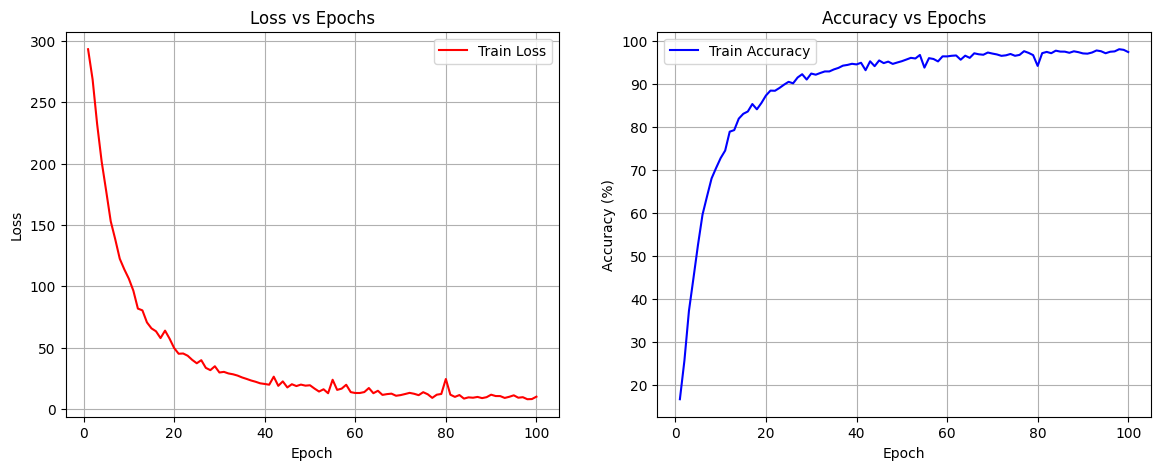

In [23]:
epochs = range(1, len(loss_list) + 1)

plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_list, label='Train Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.grid(True)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_list, label='Train Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.grid(True)
plt.legend()

plt.show()


In [24]:
!pip install -q huggingface_hub

from huggingface_hub import login
login()   # paste your HF token when prompted

In [25]:
import os, json, torch

save_dir = "vit_paddy_pytorch"
os.makedirs(save_dir, exist_ok=True)

# 1) save weights
torch.save(model.state_dict(), os.path.join(save_dir, "pytorch_model.bin"))

# 2) save config so you can rebuild the model later
config = {
    "model_type": "custom_vit_paddy",
    "image_size": image_size,
    "num_channels": num_channels,
    "patch_size": patch_size,
    "num_patches": num_patches,
    "token_dim": token_dim,
    "num_heads": num_heads,
    "transformer_blocks": transformer_blocks,
    "mlp_hidden_dim": mlp_hidden_dim,
    "num_classes": num_classes,
}

with open(os.path.join(save_dir, "config.json"), "w") as f:
    json.dump(config, f, indent=2)

# 3) (optional but recommended) simple model card
readme_text = f"""
# ViT Paddy Disease Classifier

- Architecture: Custom Vision Transformer in PyTorch
- Classes: {num_classes} paddy diseases + normal
- Image size: {image_size}x{image_size}
- Train accuracy (final): 97.35%
- Val accuracy (final): 93.32%
"""

with open(os.path.join(save_dir, "README.md"), "w") as f:
    f.write(readme_text)


In [26]:
from huggingface_hub import create_repo, upload_folder

repo_id = "prashanth2000/vit-paddy-disease-classifier"

# create the repo (does nothing if it already exists)
create_repo(repo_id, exist_ok=True)

# upload everything in the folder
upload_folder(
    repo_id=repo_id,
    folder_path=save_dir,
    commit_message="Add ViT paddy disease model"
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/hf_api.py:9662: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...pytorch/pytorch_model.bin:   3%|3         |  561kB / 17.9MB            

CommitInfo(commit_url='https://huggingface.co/prashanth2000/vit-paddy-disease-classifier/commit/9725763a34c4a29dcaa5b4954da19a51bf15b53c', commit_message='Add ViT paddy disease model', commit_description='', oid='9725763a34c4a29dcaa5b4954da19a51bf15b53c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/prashanth2000/vit-paddy-disease-classifier', endpoint='https://huggingface.co', repo_type='model', repo_id='prashanth2000/vit-paddy-disease-classifier'), pr_revision=None, pr_num=None)

In [27]:
torch.save(model.state_dict(), "vit_paddy_disease.pth")